<a href="https://colab.research.google.com/github/ltbatis/sensor-logs-processing/blob/main/src/shape_tech_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shape tech-test

Before the resolutions of the exercises I would like to propose some designs that probably in the business scope, would most likely be the architectures that I would try to adopt and give preference. 

### *First proposal*
This first proposal is based on the fact that the files would be periodically added to a storage in the cloud, it would use Data Factory to do the orchestration, calling for example a Job in Databricks that could be similar to the notebook that will be presented below, this would do transformation, and then we would still have two possibilities, save these results in a result file in the Storage itself or in a database, to be later consumed by a data visualization tool/team.

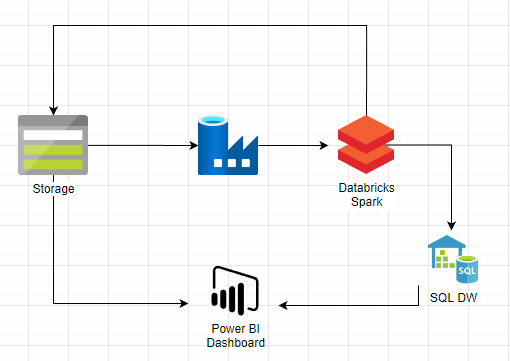

### *Second proposoal*
The second one is more event-driven oriented, is more suitable for when there is a need to create forecasts as close to real time as possible, to be alerted before problems happen, we can, for instance, associate this architecture with some machine learning models or time series capable of alarming when a equipment is close to fail through its vibration and temperature. Thus, it can be something more preventive and less adhoc.
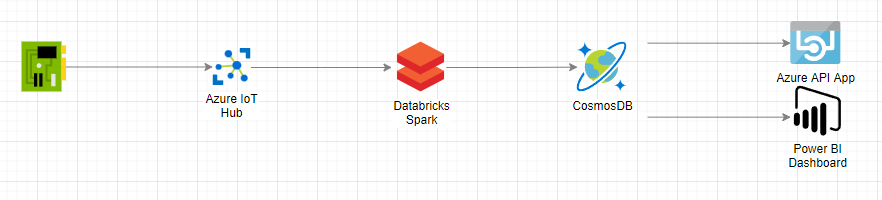

Now that possible architectures for the solution have been demonstrated, I will proceed with a transformation step using Python with the Pandas library. To solve the exercises, a collaborative cloud environment called Google Colab was chosen, and Python languages were used with the Pandas library, which can easily be replaced by the Spark framework in other languages such as Scala and Java. This step can also be fitted into the architectures proposed above, in the processing step where we use Databricks, in this case, it could execute both Jobs in Pandas, or in Spark, or even using Spark's SQL API, and most likely would be able to follow the same format that was used in the exercise below.

# Sensor logs data processing

#### Following, transformations and joins will be applied to data from different sources to analyze some metrics requested by the business team.
#### This stage of the process is the transformation stage, where we will start with raw data to calculate information that can somehow bring value to the user.

## *Goals*
- Connect to Google Drive to access the three data files
  - [equipment.json](https://drive.google.com/file/d/15Q2krI3CUZgsL1uBMe0YLl21ij3pcNg8/view?usp=sharing)
  - [equipment_failure_sensors.log](https://drive.google.com/file/d/1cLVJg02utFGF3WyiHYjH41n1dgcC-FPB/view?usp=sharing)
  - [equipment_sensors.csv](https://drive.google.com/file/d/1RuiHtyTfgA_F9V-rXo5i0lfcfDiJrPas/view?usp=sharing)
- Load and Analyze the data using Python pandas
- Transform the data to clearly obtain the following results:
  - Total equipment failures that happened? [See here](#scrollTo=JjAW8TRAzo4w)
  - Which equipment code had most failures? [See here](#scrollTo=8tNYc9BiTtL5)
  - Average amount of failures across equipment group, ordered by the number of failures in ascending order? [See here](#scrollTo=ydLRDnf_DcRv)

In [376]:
# import libraries
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# mount the Google Drive and reading files
drive.mount('/content/gdrive')
dir_path = '/content/gdrive/MyDrive/Sharing/shape_data/'

sensors = pd.read_csv(dir_path + 'equipment_sensors.csv', sep=';')
equipments = pd.read_json(dir_path + 'equipment.json')
failures_stage = pd.read_csv(dir_path + 'equipment_failure_sensors.log', sep='\t', header=None)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Tasks:
- Turn *equipment_failure_sensors.log* more readable and tabular
- Convert sensor_id from *equipment_sensors.csv* to String
- Create an unique table that all informations can be retrived 
- Convert the datetime on log file to Timestamp
- Create a January 2020 filter
- Retrieve the results

In [377]:
# this step we apply some functions to create a tabular dataframe from the failures initial df
failures_stage['timestamp'] = failures_stage[0].apply(lambda st: st[st.find("[")+1:st.find("]")])
failures_stage['timestamp'] = pd.to_datetime(failures_stage['timestamp'])
failures_stage['alert'] = failures_stage[1]
failures_stage['sensor_id'] = failures_stage[2].apply(lambda st: st[st.find("[")+1:st.find("]")])
failures_stage['temperature'] = failures_stage[4].str.split(',', expand=True)[0]
failures_stage['vibration'] = failures_stage[5].str.split(')', expand=True)[0]
failures = failures_stage.drop([0, 1, 2, 3, 4, 5], axis = 1)

In [378]:
# convert sensors.sensor_id to string
sensors['sensor_id'] = sensors['sensor_id'].apply(str)

In [379]:
# make a join between the three dataframes (three files)
df = failures.join(sensors.set_index('sensor_id'), on='sensor_id').join(equipments.set_index("equipment_id"), on='equipment_id')

# create a mask that filters January 2020
mask_jan2020 = df['timestamp'].map(lambda x: (x.year, x.month)) == (2020,1)
df_jan_2020 = df[mask_jan2020]

In [380]:
# showing the total failure grouped by equipment_id
equipment_count = df_jan_2020.groupby(['equipment_id'])['equipment_id'].count()
equipment_count

equipment_id
1      528
2      904
3     1377
4      742
5      990
6      903
7      720
8      928
9      762
10     819
11     812
12     999
13    1161
Name: equipment_id, dtype: int64

In [381]:
# January 2020 total failure that happened
total_failure = df_jan_2020['equipment_id'].count()
print("In January 2020 happened a total of " + str(total_failure) + " equipment failures")

In January 2020 happened a total of 11645 equipment failures


In January 2020 the Equipment that failed most was 3 with 1377 failures in total.



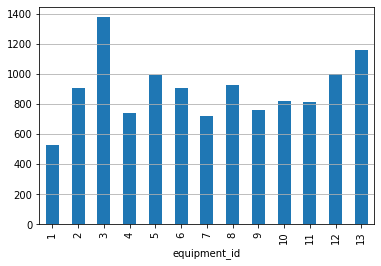

In [399]:
# find the equipment that failed most 
df_jan_2020.groupby(['equipment_id'])['equipment_id'].count().plot(y="total_failures", kind="bar")
equipment_id = df_jan_2020.groupby(['equipment_id'])['equipment_id'].count().idxmax() 
quantity_fail = df_jan_2020.groupby(['equipment_id'])['equipment_id'].count().max() 
print("In January 2020 the Equipment that failed most was " + str(equipment_id) + " with " + str(quantity_fail) + " failures in total.")
print()
plt.grid(axis='y')
plt.show()

In [393]:
# failures grouped by group_name and code, and sorted by group_name, code and failures decreasing
fail_group = df_jan_2020.groupby(['group_name', 'code']).size().reset_index(name='failures').sort_values(['group_name', 'code', 'failures'], ascending=False)
print(fail_group)

   group_name      code  failures
12   Z9K1SAP4  4E834E81      1161
11   VAPQY59S  43B81579       904
10   VAPQY59S  3329175B       762
9    PA92NCXZ  9AD15F7E       903
8    PA92NCXZ  09C37FB8       812
7    NQWPA8D3  98B84035       819
6    NQWPA8D3  86083278       928
5    FGHQWR2Q  E54B5C3A       720
4    FGHQWR2Q  E1AD07D4      1377
3    FGHQWR2Q  CF304D24       999
2    FGHQWR2Q  5310B9D7       528
1    9N127Z5P  ADE40E7F       742
0    9N127Z5P  78FFAD0C       990


            avg_failures
group_name              
Z9K1SAP4          1161.0
FGHQWR2Q           906.0
NQWPA8D3           873.5
9N127Z5P           866.0
PA92NCXZ           857.5
VAPQY59S           833.0



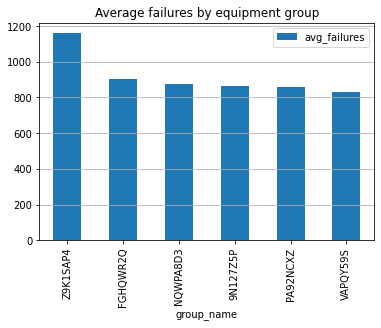

In [401]:
avg_failure_group = fail_group.groupby('group_name').mean().sort_values(['failures'], ascending=False)
avg_failure_group.columns = ['avg_failures']
print(avg_failure_group)
print()
avg_failure_group.plot(y='avg_failures', kind = 'bar', title = "Average failures by equipment group")
plt.grid(axis='y')
plt.show()